In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
def  mergedfs(df_users, df_pic,df_desc, df_tweets, df_media, df_text):
    df_user = df_users.merge(df_pic, on = "user_id",how = "left")
    df_user = df_user.merge(df_desc, on = "user_id",how = "left")
    df_all = df_tweets.merge(df_media, on = "tweet_id",how = "left")
    df_all = df_all.drop_duplicates(subset = ["tweet_id"])
    df_user = df_user.rename(columns={"user_id":"tweet_user_id"})
    df_all = df_all.merge(df_text, on = "tweet_id")
    df_all = df_all.merge(df_user, on = "tweet_user_id",how = "left")
    df = df_all.drop(['tweet_id','tweet_topic_ids','media_id'], axis = 1)
    df = df.fillna(0)
    le = LabelEncoder()
    df["tweet_attachment_class"]= le.fit_transform(df.tweet_attachment_class.values)
    return df

In [ ]:
def retrievelabels(df_all):
    df_all["virality"] = df_all["virality"] - 1
    labels = df_all.pop("virality").to_numpy(dtype = "int32")
    return labels, df_all

In [ ]:
from sklearn.decomposition import TruncatedSVD
def preprocess(df_train):#, df_test):
    #df = pd.concat([df_train, df_test])
    data = df_train.to_numpy(dtype = "float32")    
    #scaler = preprocessing.MinMaxScaler()
    #data = scaler.fit_transform(data)
    svd = TruncatedSVD(n_components=241, n_iter=10, random_state=42)
    data = svd.fit_transform(data)
    #for i in range (data.shape[1]):
        #if min(data[:,i]) < 0:
            #data[:,i] = data[:,i] + abs(min(data[:,i]))
    #scaler = preprocessing.MinMaxScaler()
    #data = scaler.fit_transform(data)
    #X_s = StandardScaler().fit_transform(data)
    #pca = PCA(n_components=200)
    #data = pca.fit_transform(X_s)
    return data

In [ ]:
def csvsave(file,y_pred,df_tweets1):
    y_pred = y_pred+1
    df_final = df_tweets1["tweet_id"].to_frame()
    df_final.insert(1, "virality", y_pred)
    df_final.to_csv(file, index = False)

In [ ]:
import math
def ClassWeights(my_list):
     
   # Creating an empty dictionary
    count = {}
    for i in my_list:
        count[i] = count.get(i, 0) + 1
    total = sum(count.values())
    for i in range(len(count.values())):
        count[i] = (total)/(3*count[i])
    return count

In [ ]:
df_media = pd.read_csv("drive/MyDrive/Dataset/Tweets/train_tweets_vectorized_media.csv")
df_tweets = pd.read_csv("drive/MyDrive/Dataset/Tweets/train_tweets.csv")
#df_tweets = df_tweets.sort_values(by='tweet_id')
df_text = pd.read_csv("drive/MyDrive/Dataset/Tweets/train_tweets_vectorized_text.csv")
df_media1 = pd.read_csv("drive/MyDrive/Dataset/Tweets/test_tweets_vectorized_media.csv")
df_tweets1 = pd.read_csv("drive/MyDrive/Dataset/Tweets/test_tweets.csv")
#df_tweets1 = df_tweets1.sort_values(by='tweet_id')
df_text1 = pd.read_csv("drive/MyDrive/Dataset/Tweets/test_tweets_vectorized_text.csv")

In [ ]:
df_tweets1.shape[0] + df_tweets.shape[0]

42322

In [ ]:
df_users = pd.read_csv("drive/MyDrive/Dataset/Users/users.csv")
df_pic = pd.read_csv("drive/MyDrive/Dataset/Users/user_vectorized_profile_images.csv")
df_desc = pd.read_csv("drive/MyDrive/Dataset/Users/user_vectorized_descriptions.csv")

In [ ]:
df_tweets.tweet_created_at_year.unique()

array([2015, 2020, 2019, 2016, 2021, 2018, 2017, 2013, 2014])

In [ ]:
oh = pd.get_dummies(df_tweets['tweet_created_at_year'], prefix='year')
df_tweets = pd.concat([df_tweets, oh])

In [ ]:
df_train = mergedfs(df_users, df_pic,df_desc, df_tweets, df_media, df_text)
labels,df_train = retrievelabels(df_train)
df_test = mergedfs(df_users, df_pic,df_desc, df_tweets1, df_media1, df_text1)
print(df_test.shape)
print(df_train.shape)

(12697, 5653)
(29625, 5662)


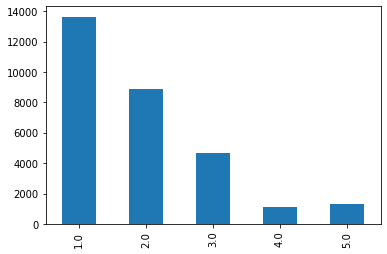

In [ ]:
df_tweets['virality'].value_counts().sort_index().plot.bar(x='Classes', y='Number of Samples')

In [ ]:
df_train.isnull().values.any()

False

In [ ]:
df_test.isnull().values.any()

False

In [ ]:
data = preprocess(df_train)#, df_test)
np.shape(data)

(29625, 241)

In [ ]:
X_train = data

In [ ]:
X_train = data[0:df_train.shape[0],:]
print(X_train.shape)
X_test = data[df_train.shape[0]:df_train.shape[0]+df_test.shape[0],:]
print(X_test.shape)

(29625, 241)
(12697, 241)


In [ ]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_train, labels, test_size = 0.1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=26)
neigh.fit(X_train1, y_train1)
y2 = (neigh.predict(X_test1))
accuracy_score(y2,y_test1)

0.6415794802564968

In [ ]:
classweights = ClassWeights(labels)
classweights_i = classweights.items()
classweights = dict(sorted(classweights_i))
dict(classweights)

{0: 0.7243984741784038,
 1: 1.1109236134548317,
 2: 2.125484287559191,
 3: 8.700440528634362,
 4: 7.464096749811035}

## Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight="balanced",
                                         criterion='gini', max_depth=70, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=1, min_samples_split=5,
                                         min_weight_fraction_leaf=0.0, n_estimators=1600, 
                                         n_jobs=None, oob_score=False, random_state=None, verbose=0,warm_start=False)
  
# Training the model
extra_tree_forest.fit(X_train1, y_train1)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=70, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=1600,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
y2 = extra_tree_forest.predict(X_test1)
print(accuracy_score(y2,y_test1))

0.6780290246371921


## Feature importances
To check the number of features approximately needed for good predictions

In [ ]:
rf.feature_importances_
# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_list = list(df_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

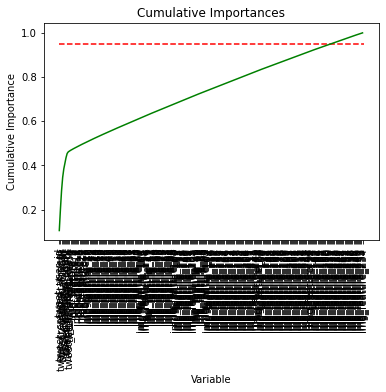

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
x_values = list(range(len(importances)))
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');


In [ ]:
sorted_importances[20]

0.0026

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 243


In [ ]:
len(feature_list)

5653

## only training data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight=classweights,n_estimators= 1600,min_samples_split= 5,min_samples_leaf= 1,max_features= 'sqrt',max_depth= 70, bootstrap = False)
rf.fit(X_train1,y_train1)
y2=rf.predict(X_test1)
print(classification_report(y_test1, y2))
confusion_matrix(y_test1, y2)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1354
           1       0.59      0.53      0.56       868
           2       0.56      0.63      0.59       481
           3       0.30      0.03      0.05       115
           4       0.68      0.43      0.53       145

    accuracy                           0.68      2963
   macro avg       0.58      0.50      0.51      2963
weighted avg       0.66      0.68      0.67      2963



array([[1190,  152,   11,    0,    1],
       [ 279,  464,  124,    0,    1],
       [  39,  123,  305,    4,   10],
       [  13,   28,   54,    3,   17],
       [   7,   19,   54,    3,   62]], dtype=int64)

## Training and test data - Final Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(class_weight=classweights)
rf = RandomForestClassifier(class_weight=classweights,n_estimators= 1600,min_samples_split= 5,min_samples_leaf= 1,max_features= 'sqrt',max_depth= 70, bootstrap = False)

rf.fit(X_train,labels)
y2=rf.predict(X_test)
csvsave("RandomForest_51.csv",y2,df_tweets1)

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 0.43463908450704225,
  1: 0.6665541680728991,
  2: 1.2752905725355144,
  3: 5.220264317180617,
  4: 4.478458049886621},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Randomised search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight=classweights)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

0.6415794802564968

In [ ]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

## Stacked Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
estimators = [
... ('knn', KNeighborsClassifier(n_neighbors=5)),
... ('lr', LogisticRegression(solver='lbfgs',max_iter=10000,class_weight=classweights))
... ]
clf = StackingClassifier(
... estimators=estimators, final_estimator=RandomForestClassifier(class_weight = classweights)
... )

In [ ]:
clf.fit(X_train1, y_train1)

StackingClassifier(cv=None,
                   estimators=[('knn',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='minkowski',
                                                     metric_params=None,
                                                     n_jobs=None, n_neighbors=5,
                                                     p=2, weights='uniform')),
                               ('lr',
                                LogisticRegression(C=1.0,
                                                   class_weight={0: 0.7243984741784038,
                                                                 1: 1.1109236134548317,
                                                                 2: 2.125484287559191,
                                                                 3: 8.700440528634362,
                                           

In [ ]:
y_pred1 = clf.predict(X_test1)
#csvsave("stacked.csv",y_pred1,df_tweets1)
print(classification_report(y_pred1, y_test1))
confusion_matrix(y_pred1, y_test1)

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1529
           1       0.48      0.52      0.50       852
           2       0.48      0.51      0.50       443
           3       0.03      0.14      0.05        29
           4       0.35      0.50      0.41       110

    accuracy                           0.61      2963
   macro avg       0.43      0.47      0.44      2963
weighted avg       0.65      0.61      0.63      2963



array([[1070,  366,   53,   20,   20],
       [ 198,  441,  161,   25,   27],
       [  11,   98,  228,   56,   50],
       [   0,    6,   14,    4,    5],
       [   6,    6,   19,   24,   55]])

## REFERENCES



1.  https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
2.   https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74



